In [16]:
import zipline
from sklearn.linear_model import LinearRegression
from zipline.pipeline.data import USEquityPricing
from zipline.pipeline.factors.basic import AverageDollarVolume
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pandas_datareader.data as web
from datetime import datetime

### Factor Model 
* Taken from [this](https://www.quantopian.com/lectures/fundamental-factor-models)
* The idea is to model returns as a function of the factors that contribute to those returns
* Rt=αt+ βt,F1F1 + βt,F2F2 +...+ βt,FkFk + ϵt
* F is the Factor return strem
* β is Factor exposure
* Rt is the return of an asset for time step t

In [17]:
iex_data = xr.open_zarr('iex_data')

In [18]:
iex_data['date'] = pd.to_datetime(iex_data['date'])

In [19]:
def construct_ds(ticker, data_source, start, end):
    '''
    
    Takes a ticker symbol and data source and using 
    `pandas_datareader` it will retrieve price history
    for a ticker. Once ticker is retrieved, converts the 
    contents of the dataframe to an xarray Dataset
    
    
    Parameters
    ==========
    
    ticker: str
    data_source: str
    start: datetime object
    end: datetime object
    
    Returns
    =======
    xr.Dataset
    
    '''
    
    import pandas_datareader.data as web
    
    
    sec = web.DataReader(ticker, data_source, start, end)
    
    ds = xr.Dataset({'open':(['date'], sec['open']),
                 'high':(['date'], sec['high']),
                 'low':(['date'], sec['low']),
                 'close':([ 'date'], sec['close']),
                 'volume':([ 'date'], sec['volume'])},
                coords={'date':(['date'], sec.index),
                        'ticker': ticker})
    
    return ds

In [20]:
def compute_momentum(da, period):
    '''
    Computes simple moving average for given period
    
    Parameters
    ==========
    da: xr.DataArray
    period: int
    
    '''
    ma = da.rolling(date=period).mean()
    return ma

In [35]:
def compute_returns_xr(da, dim, period):
    '''
    Computes returns/percent change over period for a given dimension
    
    
    Parameters
    ==========
    da: xr.DataArray
    dim: str of dimension to shift
    period: int 
    
    Returns
    =======
    xr.DataArray of percentage change for given period along dim
    '''
    
    return (da - da.shift(**{dim: period}))/ da.shift(**{dim: period})

In [149]:

def factor_returns_xr(pca, coords, dims):
    '''
    Constructs new dataframe with pca object principal components
    in the original basis coordinate system
    
    Parameters
    ==========
    pca: 
        sklearn.decomposition.PCA object fitted with returns df
    
    coords: a list or dictionary of coordinates. 
                If a list, it should be a list of tuples where the first element 
                is the dimension name and the second element is the corresponding 
                coordinate array_like object.
                
    dims: a list of dimension names. If omitted and coords 
            is a list of tuples, dimension names are taken from coords.
        
        
    Returns
    =======
    
    pd.Dataframe with factor_beta_indices as rows and factor_beta_columns as columns
    
    '''
        
    return xr.DataArray(
                        data=pca.components_.T, 
                        coords=coords, 
                        dims=dims
                        )
    


In [136]:
from sklearn.decomposition import PCA

def fit_pca(returns, num_factor_exposures, svd_solver):
    '''
    Wrapper for sklearn PCA class
    
    Parameters
    ==========
    returns: pd.DataFrame
    num_factor_exposures: int
    svd_solver: string for 
    
    Returns
    =======
    sklearn.decomposition.PCA object fitted with the returns values
    '''
    pca = PCA(
            n_components=num_factor_exposures, 
            svd_solver=svd_solver)
    
    pca.fit(returns)
    
    return pca
    


In [150]:
import pandas as pd 

def factor_exposure_xr(pca, returns):
    '''
    Uses sklearn pca.transform to project returns into the new basis. 
    Returns the factor returns for in the new basis.
    
    Parameters
    ==========
    pca: 
        sklearn.decomposition.PCA object fitted with returns df
        

        
    Returns
    =======
    
    xr.DataArray of returns in the new basis 
        
    
    '''
    
    components = pca.transform(returns)
    return xr.DataArray(components, 
                        coords=[returns['ticker'], ['principal_component_{}'.format(i) for i in range(1,components.shape[1]+1)]], 
                        dims=['ticker', 'principal_component']
                       )
                        

In [157]:
def idiosyncratic_var_matrix_xr(returns, factor_returns, factor_betas, ann_factor):
    '''
    Our matrix of residuals that represents the difference of the observed returns minus
    the product of factor returns matrix and beta factors matrix. 
    
    Parameters
    ==========
    returns: pd.DataFrame of asset returns of shape N companies by M time steps
    factor_returns: pd.DataFrame of asset returns in the new basis
    factor_betas: pd.DataFrame of betas for the principal components
    ann_factor: annualization factor
    
    Returns
    =======
    pd.DataFrame of residuals with the 
        annualized Idiosyncratic Risk Matrix containing the 
        covariance of the residuals in its main diagonal
    
    '''
    common_returns_ = factor_returns.dot(factor_betas.T)
    
    residuals_ = (returns - common_returns_)
    
    return xr.DataArray(np.diag(np.var(residuals_.values))*ann_factor, returns.coords, returns.dims)
    


In [36]:
##backfill data 
iex_data['close'] = iex_data['close'].bfill(dim='date')

In [37]:
# da_20 = compute_momentum(iex_data['close'], 20)
# da_50 = compute_momentum(iex_data['close'], 50)
daily_returns = compute_returns_xr(iex_data['close'], 'date', 1)
# volume_momentum_20 = compute_momentum(iex_data['volume'], 20)
# volume_momentum_50 = compute_momentum(iex_data['volume'], 50)

In [14]:
# factor_ds = xr.Dataset()
# factor_ds['20_day_momentum_close'] = da_20
# factor_ds['50_day_momentum_close'] = da_50
# factor_ds['50_day_momentum_vol'] = volume_momentum_50
# factor_ds['20_day_momentum_vol'] = volume_momentum_20
# factor_ds['daily_returns'] = daily_returns

In [155]:
#Find our last day in the series to slice along
factor_ds['date'][-1]

<xarray.DataArray 'date' ()>
array('2019-01-04T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    date     datetime64[ns] 2019-01-04

In [30]:
#constrain our start and end dates to those time periods 
# where we have both returns and factor data
#factor_ds_with_dates = factor_ds.sel(date=slice('2015-01-14','2019-01-04'))


In [148]:
#now lets set to pd.MultiIndex
#factor_ds_with_dates_df = factor_ds_with_dates.to_dataframe()

In [178]:
#bil = construct_ds('BIL', 'iex','2015-03-10','2019-01-04')
#bil_returns = compute_returns_xr(bil['close'], 'date', 1).sel(date=slice('2015-03-14','2019-01-04')).load()

5y


In [166]:
s#py = xr.open_zarr('spy_data/').sel(date=slice('2015-03-14','2019-01-04'))

In [177]:
#spy_returns = spy['daily_returns'].sel(date=slice('2015-03-14','2019-01-04')).load()

In [179]:
#bil_returns

<xarray.DataArray 'close' (date: 960)>
array([ 0.      ,  0.      , -0.000109, ..., -0.000109,  0.000328,  0.000109])
Coordinates:
  * date     (date) object '2015-03-16' '2015-03-17' '2015-03-18' ...
    ticker   <U3 'BIL'

In [180]:
## Lets now rank our momentum and volume factors into biggest and smallest

In [38]:
# #get top and bottom for each factor

# rank_ma_20 = factor_ds_with_dates['20_day_momentum_close'].rank(dim='ticker')
# most_ma_20 = xr.where(rank_ma_20 >= 1102, 1, 0)
# least_ma_20 = xr.where(rank_ma_20 <= 100, 1, 0)

# rank_ma_50 = factor_ds_with_dates['50_day_momentum_close'].rank(dim='ticker')
# most_ma_50 = xr.where(rank_ma_50 >= 1102, 1, 0)
# least_ma_50 = xr.where(rank_ma_50 <= 100, 1, 0)

# rank_vol_20 = factor_ds_with_dates['20_day_momentum_vol'].rank(dim='ticker')
# most_vol_20 = xr.where(rank_vol_20 >= 1102, 1, 0)
# least_vol_20 = xr.where(rank_vol_20 <= 100, 1, 0)

# rank_vol_50 = factor_ds_with_dates['50_day_momentum_vol'].rank(dim='ticker')
# most_vol_50 = xr.where(rank_vol_50 >= 1102, 1, 0)
# least_vol_50 = xr.where(rank_vol_50 <= 100, 1, 0)

In [369]:
# #lets set up our factors
# #average_daily_return by factor
# mean_return_most_ma_20 = (most_ma_20 * factor_ds_with_dates['daily_returns']).mean(dim='ticker')
# mean_return_least_ma_20 = (least_ma_20 * factor_ds_with_dates['daily_returns']).mean(dim='ticker')


# mean_return_most_ma_50 = (most_ma_50 * factor_ds_with_dates['daily_returns']).mean(dim='ticker')
# mean_return_least_ma_50 = (least_ma_50 * factor_ds_with_dates['daily_returns']).mean(dim='ticker')

# ####### aborting use of volume as factor ###########
# # mean_return_most_vol_20 = (most_vol_20 * factor_ds_with_dates['daily_returns']).mean(dim='ticker')
# # mean_return_most_vol_50 = (most_vol_50 * factor_ds_with_dates['daily_returns']).mean(dim='ticker')

In [370]:
# ma_20_factor_return = mean_return_most_ma_20 - mean_return_least_ma_20
# ma_50_factor_return = mean_return_most_ma_50 - mean_return_least_ma_50
# exmarkt = spy_returns - bil_returns

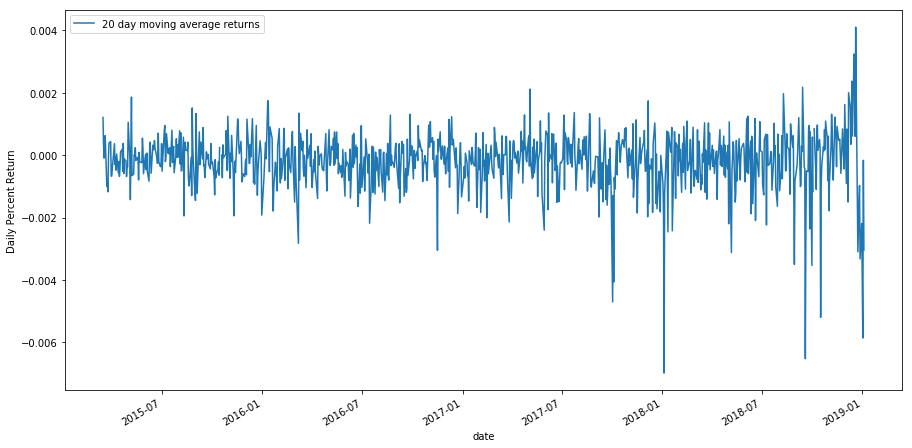

In [371]:
#for visual effect we remove the outlier values so we can see how this looks 
ma_20_factor_return.where(ma_20_factor_return > -.3 ).plot(figsize=(15,7));
plt.ylabel('Daily Percent Return')
plt.legend(['20 day moving average returns']);

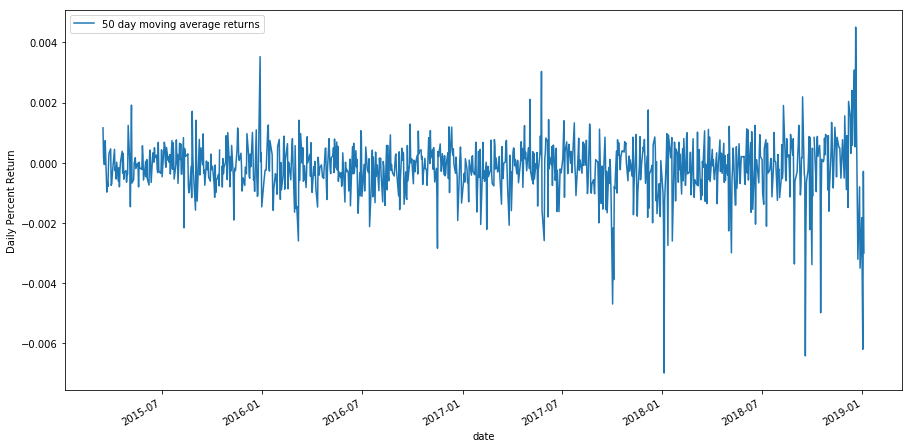

In [372]:
#for visual effect we remove the outlier values so we can see how this looks 
ma_50_factor_return.where(ma_50_factor_return > -.3).plot(figsize=(15,7));
plt.ylabel('Daily Percent Return')
plt.legend(['50 day moving average returns']);

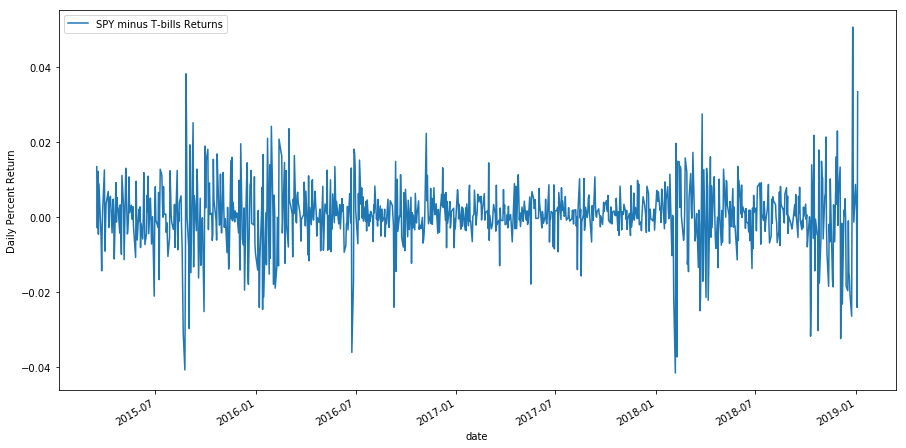

In [373]:
exmarkt.plot(figsize=(15,7))
plt.ylabel('Daily Percent Return')
plt.legend(['SPY minus T-bills Returns']);